In [1]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

import utils
import color_manipulation as cm

from HSV_manipulations import get_HSV_RGB
from color_pixel_projection import recolor_image, plot_color_wheel, plot_color_axis

results_dir = "results/image_recoloring/color_pixel_projections/"

In [2]:
# img_file = 'nicholas-roerich_tent-mountain-1933.jpg'
# img_file = 'pathay.jpeg'
# img_file = 'adnan-coker_unknown-title(3).jpg'
# img_file = 'ad-reinhardt_yellow-painting-1949.jpg'
img_file = 'Summer.jpg'

img_dir = "images/" # Image directory
results_dir = "results/image_recoloring/color_pixel_projections/" # Where to save the altered images
os.makedirs(results_dir, exist_ok=True) # Creates results_dir if it does not exist

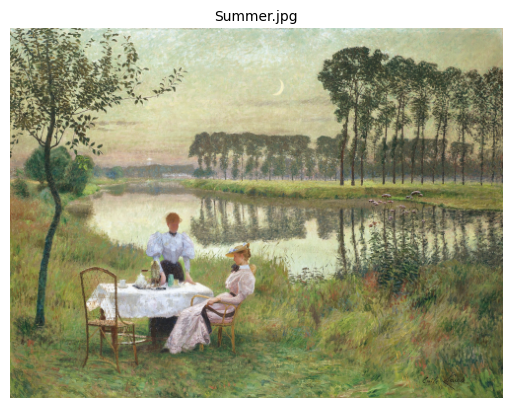

In [3]:
bgr_img = cv2.imread(img_dir + img_file) # cv2 encodes images in BGR
bgr_img = utils.resize_max_dim(bgr_img, 500) # Resize image if too large
rgb_img = bgr_img[:, :, ::-1] # Converts BGR to RGB
utils.imshow(rgb_img, img_file)

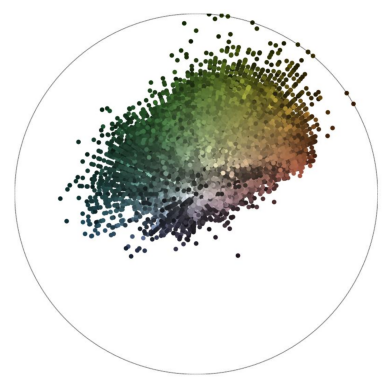

In [4]:
hsv_img, rgb_img = get_HSV_RGB(img_dir + img_file, scale_factor=1)

# Downsample pixels for efficiency
downsampling_factor = 10
plot_color_wheel(hsv_img, results_dir+'colorwheel.jpg', downsampling_factor=downsampling_factor)

Mean hue: 65.44 degrees


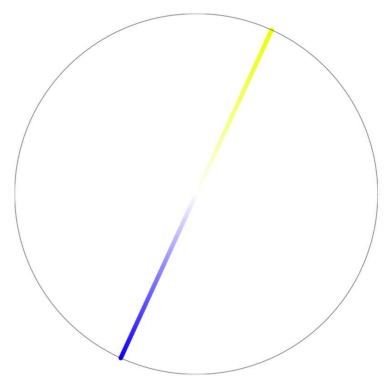

In [5]:
mean_hue = cm.mean_hue_from_hsv(hsv_img)

print(f"Mean hue: {mean_hue:.2f} degrees")

plot_color_axis(mean_hue, results_dir, n_pixels=100)

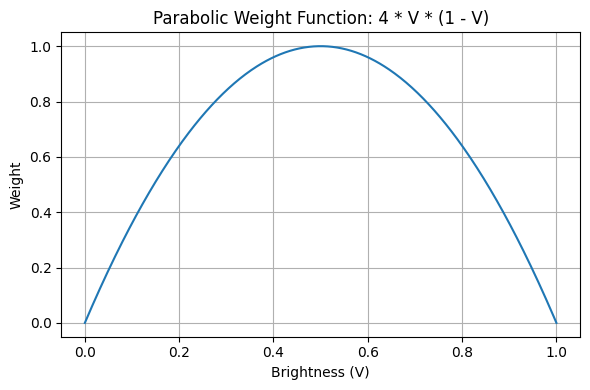

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_parabolic_weight():
    """
    Plots the inverted-U parabolic weighting function:
        w(V) = 4 * V * (1 - V)
    where V is in [0, 1].
    """
    V = np.linspace(0, 1, 500)
    w = 4 * V * (1 - V)

    plt.figure(figsize=(6, 4))
    plt.plot(V, w)
    plt.title("Parabolic Weight Function: 4 * V * (1 - V)")
    plt.xlabel("Brightness (V)")
    plt.ylabel("Weight")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_parabolic_weight()

Mean hue: 64.80 degrees


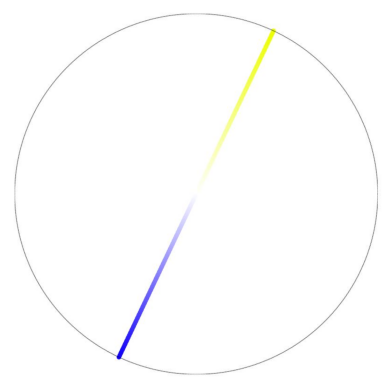

In [10]:
import numpy as np

def mean_hue_from_hsv_weighted(hsv_img: np.ndarray) -> float:
    """
    Computes the circular mean hue of an HSV image (OpenCV format),
    weighted by an inverted-U function of brightness (Value channel).
    
    Weight = 4*V*(1-V), so very dark and very bright pixels contribute less.
    Hue channel must be in [0,179].
    Value channel is [0,255].

    Returns
    -------
    float
        Weighted mean hue in degrees (0–360).
    """

    # Extract H and V channels
    hue = hsv_img[:, :, 0].astype(np.float32)
    val = hsv_img[:, :, 2].astype(np.float32) / 255.0  # normalize to [0,1]

    # Convert hue to radians (0–2π)
    rad = np.deg2rad(hue * 2.0)

    # Inverted-U weight: max at V=0.5, zero at V=0 and V=1
    weights = 4 * val * (1.0 - val)

    # Avoid division by zero
    if np.sum(weights) == 0:
        return np.nan  # or any fallback you want

    # Weighted circular mean
    mean_x = np.sum(weights * np.cos(rad)) / np.sum(weights)
    mean_y = np.sum(weights * np.sin(rad)) / np.sum(weights)

    mean_angle = np.arctan2(mean_y, mean_x)
    mean_deg = np.rad2deg(mean_angle)

    # Normalize to [0,360)
    if mean_deg < 0:
        mean_deg += 360

    return mean_deg


weighted_mean_hue = mean_hue_from_hsv_weighted(hsv_img)

print(f"Mean hue: {weighted_mean_hue:.2f} degrees")

plot_color_axis(weighted_mean_hue, results_dir, n_pixels=100)

In [4]:
def plot_color_wheel_and_two_mean_angles(
        HSV_img, 
        result_path, 
        hue_degree_1, 
        hue_degree_2,
        downsampling_factor=1, 
        n_pixels=30
    ):
    """
    Same as your original function, but now plots TWO mean hue angles
    (each with its opposite direction), side by side.

    Parameters
    ----------
    hue_degree_1 : float
        First mean hue in degrees.
    hue_degree_2 : float
        Second mean hue in degrees.
    """

    # --- COLOR WHEEL ---
    hsv_downsampled = HSV_img.transpose(2, 0, 1).reshape((3, -1)).transpose(1, 0)[::downsampling_factor]
    colors = cv2.cvtColor(HSV_img, cv2.COLOR_HSV2BGR).reshape(-1, 3)[::downsampling_factor][:, ::-1]

    theta = hsv_downsampled[:, 0].astype('float32') * 2 * np.pi / 180.0
    r = hsv_downsampled[:, 1]
    x_coordinates = r * np.cos(theta)
    y_coordinates = r * np.sin(theta)

    # Circle for boundary
    theta_circle = np.linspace(0, 2 * np.pi, 1000)
    x_circle = 255 * np.cos(theta_circle)
    y_circle = 255 * np.sin(theta_circle)

    # Helper: compute points and colors for a given hue angle
    def points_for_hue(hue_deg):
        rvals = np.linspace(0, 255, num=n_pixels, dtype=int)
        th1 = (hue_deg % 360) * np.ones(n_pixels) * np.pi / 180.0
        th2 = ((hue_deg + 180) % 360) * np.ones(n_pixels) * np.pi / 180.0

        x1 = rvals * np.cos(th1)
        y1 = rvals * np.sin(th1)
        x2 = rvals * np.cos(th2)
        y2 = rvals * np.sin(th2)

        # HSV for coloring
        h_vals = np.concatenate((th1, th2)) * 180 / np.pi / 2
        s_vals = np.concatenate((rvals, rvals))
        v_vals = np.ones_like(h_vals) * 255

        hsv_pixels = np.stack([h_vals, s_vals, v_vals], axis=1).astype(np.uint8)
        hsv_pixels = hsv_pixels.reshape((1, -1, 3))
        colors = cv2.cvtColor(hsv_pixels, cv2.COLOR_HSV2RGB).reshape((-1, 3))

        return (
            np.concatenate((x1, x2)),
            np.concatenate((y1, y2)),
            colors
        )

    # Compute for both hue degrees
    x1, y1, colors1 = points_for_hue(hue_degree_1)
    x2, y2, colors2 = points_for_hue(hue_degree_2)

    # --- PLOTTING ---
    fig, axs = plt.subplots(1, 3, figsize=(21, 7.5))

    # LEFT: Color wheel
    axs[0].scatter(x_coordinates, y_coordinates, c=colors / 255, s=5)
    axs[0].scatter(x_circle, y_circle, c=np.zeros((len(x_circle), 3)), s=0.1)
    axs[0].set_title("Color Wheel", size=20)
    axs[0].set_xlim([-255, 255])
    axs[0].set_ylim([-255, 255])
    axs[0].axis("off")

    # CENTER: First hue
    axs[1].scatter(x1, y1, c=colors1 / 255, s=20)
    axs[1].scatter(x_circle, y_circle, c=np.zeros((len(x_circle), 3)), s=0.1)
    axs[1].set_title(f"Mean Hue: {hue_degree_1:.2f}°", size=20)
    axs[1].set_xlim([-255, 255])
    axs[1].set_ylim([-255, 255])
    axs[1].axis("off")

    # RIGHT: Second hue
    axs[2].scatter(x2, y2, c=colors2 / 255, s=20)
    axs[2].scatter(x_circle, y_circle, c=np.zeros((len(x_circle), 3)), s=0.1)
    axs[2].set_title(f"Weighted Mean Hue: {hue_degree_2:.2f}°", size=20)
    axs[2].set_xlim([-255, 255])
    axs[2].set_ylim([-255, 255])
    axs[2].axis("off")

    plt.tight_layout()
    plt.savefig(result_path, dpi=300)
    plt.close()


In [5]:
import numpy as np

def mean_hue_from_hsv_linear_saturation(hsv_img: np.ndarray) -> float:
    """
    Computes the circular mean hue of an HSV image (OpenCV format),
    weighted linearly by saturation (S channel).

    Hue channel must be in [0,179].
    Saturation channel is [0,255].

    Returns
    -------
    float
        Weighted mean hue in degrees (0–360).
    """

    # Extract H and S channels
    hue = hsv_img[:, :, 0].astype(np.float32)
    sat = hsv_img[:, :, 1].astype(np.float32) / 255.0  # normalize to [0,1]

    # Convert hue to radians (0–2π)
    rad = np.deg2rad(hue * 2.0)

    # Linear weight: more saturated pixels contribute more
    weights = sat

    # Avoid division by zero
    if np.sum(weights) == 0:
        return np.nan  # or fallback

    # Weighted circular mean
    mean_x = np.sum(weights * np.cos(rad)) / np.sum(weights)
    mean_y = np.sum(weights * np.sin(rad)) / np.sum(weights)

    mean_angle = np.arctan2(mean_y, mean_x)
    mean_deg = np.rad2deg(mean_angle)

    # Normalize to [0,360)
    if mean_deg < 0:
        mean_deg += 360

    return mean_deg

       


In [7]:
input_dir = 'in/examples'
output_dir = 'out/weighted_examples_saturation'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

img_files = []
for filename in os.listdir(input_dir):
    img_files.append(filename)

In [9]:
from tqdm import tqdm

for img_file in tqdm(img_files):
    bgr_img = cv2.imread(os.path.join(input_dir, img_file))
    rgb_img = bgr_img[:, :, ::-1]
    hsv_img, img_rgb = get_HSV_RGB(os.path.join(input_dir, img_file), scale_factor=1)

    mean_hue = cm.mean_hue_from_hsv(hsv_img)
    weighted_mean_hue = mean_hue_from_hsv_linear_saturation(hsv_img)

    plot_color_wheel_and_two_mean_angles(
        hsv_img, os.path.join(output_dir, f"{os.path.splitext(img_file)[0]}_result.png"), mean_hue, weighted_mean_hue)

100%|██████████| 10/10 [03:18<00:00, 19.81s/it]
